<font size="+3"><strong>3.3. Autoregressive Models</strong></font>

In [16]:
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px

from pymongo import MongoClient
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg

warnings.simplefilter(action="ignore", category=FutureWarning)

# Prepare Data

## Import

**Task 3.3.1:** Complete to the create a client to connect to the MongoDB server, assigns the `"air-quality"` database to `db`, and assigned the `"nairobi"` connection to `nairobi`.

- [<span id='technique'>Create a client object for a <span id='tool'>MongoDB</span> instance.](../%40textbook/11-databases-mongodb.ipynb#Servers-and-Clients) 
- [<span id='technique'>Access a database using <span id='tool'>PyMongo.](../%40textbook/11-databases-mongodb.ipynb#Servers-and-Clients)
- [<span id='technique'>Access a collection in a database using <span id='tool'>PyMongo.](../%40textbook/11-databases-mongodb.ipynb#Collections)

In [17]:
client = MongoClient(host="localhost",port=27017)
db = client["air-quality"]
nairobi = db["nairobi"]

**Task 3.3.2:** Change the `wrangle` function below so that it returns a Series of the resampled data instead of a DataFrame.

In [23]:
def wrangle(collection):
    results = collection.find(
        {"site": 29, "measurement": "P2"},
        projection={"value": 1, "timestamp": 1, "_id": 0},
    )
    
    df = pd.DataFrame(results).set_index("timestamp")
    df = df.rename(columns={"value":"P2"})
    
    #Localize timezone
    df.index = df.index.tz_localize("UTC").tz_convert("Africa/Nairobi")
    
    #Remove outliers
    df = df[df["P2"]<500]
    
    #Resample to "1H" windows, ffill missing values
    y = df["P2"].resample("1H").mean().fillna(method ="ffill")
    
    
    return y

**Task 3.3.3:** Use your wrangle function to read the data from the `nairobi` collection into the Series `y`.

In [24]:
y = wrangle(nairobi)
print(y.shape)
y.head()

(2928,)


timestamp
2018-09-01 03:00:00+03:00    17.541667
2018-09-01 04:00:00+03:00    15.800000
2018-09-01 05:00:00+03:00    11.420000
2018-09-01 06:00:00+03:00    11.614167
2018-09-01 07:00:00+03:00    17.665000
Freq: H, Name: P2, dtype: float64

In [21]:
#y = ...
#y.head()

In [25]:
# Check your work
assert isinstance(y, pd.Series), f"`y` should be a Series, not type {type(y)}"
assert len(y) == 2928, f"`y` should have 2928 observations, not {len(y)}"
assert y.isnull().sum() == 0

## Explore

**Task 3.3.4:** Create an ACF plot for the data in `y`. Be sure to label the x-axis as `"Lag [hours]"` and the y-axis as `"Correlation Coefficient"`.

- [What's an <span id='term'>ACF plot?](../%40textbook/17-ts-core.ipynb#ACF-Plot)
- [<span id='technique'>Create an ACF plot using <span id='tool'>statsmodels](../%40textbook/18-ts-models.ipynb#Creating-an-ACF-Plot)

In [26]:
y.corr(y.shift(12))

0.2443448833734184

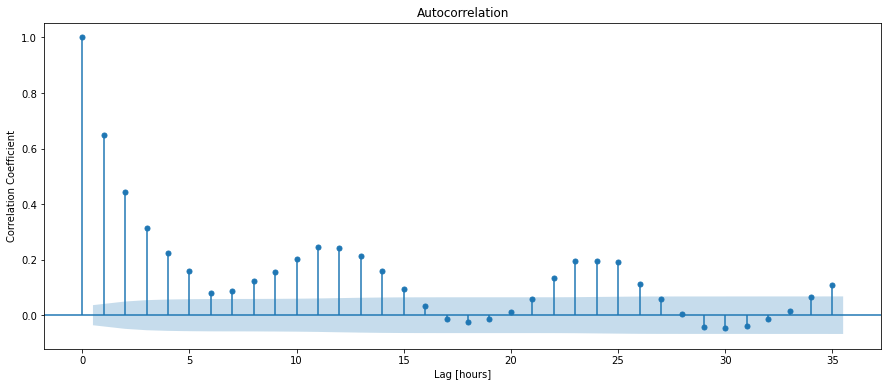

In [27]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y, ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient");

In [28]:
y.shift(2).corr(y.shift(3))

0.6506924395791185

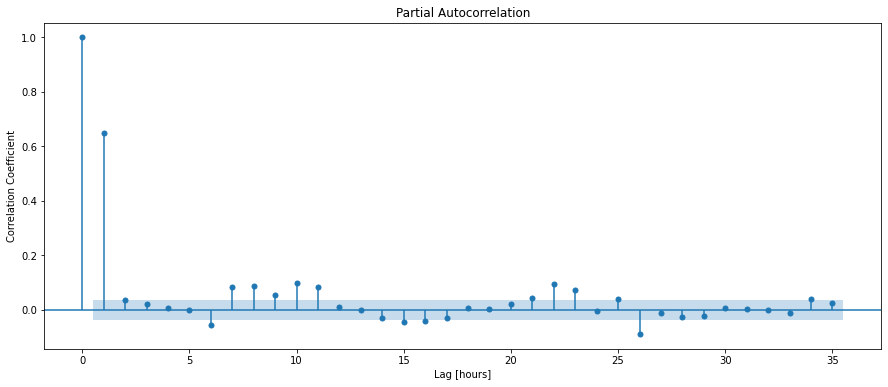

In [29]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_pacf(y, ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient");

**Task 3.3.6:** Split `y` into training and test sets. The first 95% of the data should be in your training set. The remaining 5% should be in the test set.

- [<span id='technique'>Divide data into training and test sets in <span id='tool'>pandas.](../%40textbook/18-ts-models.ipynb#Splitting-the-Data-in-pandas)

In [34]:
cutoff = int(len(y) * 0.95)

y_train = y.iloc[:cutoff]
y_test = y.iloc[cutoff:]

In [36]:
cutoff = int(len(y) * 0.95)

X_train,y_train = y.iloc[:cutoff], y.iloc[:cutoff]
X_test,y_test = y.iloc[cutoff:], y.iloc[cutoff:]

# Build Model

## Baseline

**Task 3.3.7:** Calculate the baseline mean absolute error for your model.

- [<span id='technique'>Calculate summary statistics for a DataFrame or Series in <span id='tool'>pandas.](../%40textbook/04-pandas-advanced.ipynb#Calculate-Summary-Statistics-for-a-DataFrame-or-Series)

In [37]:
y_train_mean = y_train.mean()
y_pred_baseline = [y_train_mean] * len(y_train)
mae_baseline = mean_absolute_error(y_train,y_pred_baseline)

print("Mean P2 Reading:", round(y_train_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean P2 Reading: 9.22
Baseline MAE: 3.71


## Iterate

**Task 3.3.8:** Instantiate an [`AutoReg`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.ar_model.AutoReg.html) model and fit it to the training data `y_train`. Be sure to set the `lags` argument to `26`.

- [What's an <span id='term'>AR model?](../%40textbook/17-ts-core.ipynb#Autoregression-Models)
- [<span id='technique'>Instantiate a predictor in <span id='tool'>statsmodels.](../%40textbook/18-ts-models.ipynb#Splitting-the-Data-in-pandas)
- [<span id='technique'>Train a model in <span id='tool'>statsmodels.](../%40textbook/18-ts-models.ipynb#Iterating)

In [38]:
model = AutoReg(y_train,lags=26).fit()

**Task 3.3.9:** Generate a list of training predictions for your model and use them to calculate your training mean absolute error. 

- [<span id='technique'>Generate in-sample predictions for a model in <span id='tool'>statsmodels.](../%40textbook/18-ts-models.ipynb#Iterating)
- [<span id='technique'>Calculate the mean absolute error for a list of predictions in <span id='tool'>scikit-learn.](../%40textbook/15-ml-regression.ipynb#Calculating-the-Mean-Absolute-Error-for-a-List-of-Predictions)

In [39]:
model.predict().head()

timestamp
2018-09-01 03:00:00+03:00   NaN
2018-09-01 04:00:00+03:00   NaN
2018-09-01 05:00:00+03:00   NaN
2018-09-01 06:00:00+03:00   NaN
2018-09-01 07:00:00+03:00   NaN
Freq: H, dtype: float64

In [40]:
model.predict().isnull().sum()

26

In [41]:
y_pred = model.predict().dropna()
training_mae = mean_absolute_error(y_train.iloc[26:] ,y_pred)
print("Training MAE:", training_mae)

Training MAE: 2.281303238144458


**Task 3.3.10:** Use `y_train` and `y_pred` to calculate the residuals for your model.

- [What's a <span id='term'>residual?](../%40textbook/12-ml-core.ipynb#Residuals)
- [<span id='technique'>Create new columns derived from existing columns in a DataFrame using <span id='tool'>pandas.](../%40textbook/03-pandas-getting-started.ipynb#Adding-Columns)

In [42]:
y_train_resid = model.resid
y_train_resid.tail()

timestamp
2018-12-25 19:00:00+03:00   -0.391842
2018-12-25 20:00:00+03:00   -1.573292
2018-12-25 21:00:00+03:00   -0.736029
2018-12-25 22:00:00+03:00   -2.022408
2018-12-25 23:00:00+03:00   -0.062279
Freq: H, dtype: float64

In [43]:
y_train_resid = ...
y_train_resid.tail()

AttributeError: 'ellipsis' object has no attribute 'tail'

**Task 3.3.11:** Create a plot of `y_train_resid`.

- [<span id='technique'>Create a line plot using <span id='tool'>pandas.](../%40textbook/07-visualization-pandas.ipynb#Line-Plots)

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
y_train_resid.plot(ylabel = "Residual Values",ax=ax);

**Task 3.3.12:** Create a histogram of `y_train_resid`.

- [<span id='technique'>Create a histogram using <span id='tool'>plotly express.](../%40textbook/06-visualization-matplotlib.ipynb#Histograms)

In [ ]:
y_train_resid.hist()
plt.xlabel("Residual Values")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals(AR-26)")

**Task 3.3.13:** Create an ACF plot of `y_train_resid`.

- [What's an <span id='term'>ACF plot?](../%40textbook/17-ts-core.ipynb#ACF-Plot)
- [<span id='technique'>Create an ACF plot using <span id='tool'>statsmodels](../%40textbook/18-ts-models.ipynb#ACF-Plots)

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y_train_resid, ax=ax);

## Evaluate

**Task 3.3.14:** Calculate the test mean absolute error for your model.

- [<span id='technique'>Generate out-of-sample predictions using model in <span id='tool'>statsmodels.](../%40textbook/18-ts-models.ipynb#Out-of-Sample-Predictions)
- [<span id='technique'>Calculate the mean absolute error for a list of predictions in <span id='tool'>scikit-learn.](../%40textbook/15-ml-regression.ipynb#Calculating-the-Mean-Absolute-Error-for-a-List-of-Predictions)

In [ ]:
len(y_test)

In [ ]:
y_pred_test = model.predict(y_test.index.min(),y_test.index.max())
test_mae = mean_absolute_error(y_test,y_pred_test)
print("Test MAE:", test_mae)

In [ ]:
y_test.head(10)

In [ ]:
len(y_pred_test)

**Task 3.3.15:** Create a DataFrame `test_predictions` that has two columns: `"y_test"` and `"y_pred"`. The first should contain the true values for your test set, and the second should contain your model's predictions. Be sure the index of `test_predictions` matches the index of `y_test`.

- [<span id='technique'>Create a DataFrame from a dictionary using <span id='tool'>pandas.](../%40textbook/03-pandas-getting-started.ipynb#Working-with-DataFrames)

In [7]:
df_pred_test = pd.DataFrame(
    {"y_test": y_test, "y_pred": y_pred_test}, index=y_test.index
)

NameError: name 'y_test' is not defined

**Task 3.3.16:** Create a time series plot for the values in `test_predictions` using plotly express. Be sure that the y-axis is properly labeled as `"P2"`.

- [<span id='technique'>Create a line plot in <span id='tool'>plotly express.](../%40textbook/07-visualization-pandas.ipynb#Line-Plots)

In [6]:
fig = px.line(df_pred_test, labels={"value": "P2"})
fig.show()

NameError: name 'df_pred_test' is not defined

**Task 3.3.17:** Perform walk-forward validation for your model for the entire test set `y_test`. Store your model's predictions in the Series `y_pred_wfv`. 

- [What's <span id='term'>walk-forward validation?](../%40textbook/17-ts-core.ipynb#Walk-Forward-Validation)
- [<span id='technique'>Perform walk-forward validation for time series model.](../%40textbook/18-ts-models.ipynb#Walk-forward-Validation)

In [ ]:
%%capture

y_pred_wfv = pd.Series()
history = y_train.copy()
for i in range(len(y_test)):
    model = AutoReg(history,lags=26).fit()
    next_pred = model.forecast()
    y_pred_wfv = y_pred_wfv.append(next_pred)
    history = history.append(y_test[next_pred.index])
    

In [ ]:
history.tail(1)

In [ ]:
y_test.head(1)

In [ ]:
model = AutoReg(history,lags=26).fit()

In [ ]:
model.forecast().index

**Task 3.3.18:** Calculate the test mean absolute error for your model.

- [<span id='technique'>Calculate the mean absolute error for a list of predictions in <span id='tool'>scikit-learn.](../%40textbook/15-ml-regression.ipynb#Calculating-the-Mean-Absolute-Error-for-a-List-of-Predictions)

In [ ]:
test_mae = mean_absolute_error(y_test,y_pred_wfv)
print("Test MAE (walk forward validation):", round(test_mae, 2))

# Communicate Results

**Task 3.3.19:** Print out the parameters for your trained model.

- [<span id='technique'>Access model parameters in <span id='tool'>statsmodels](../%40textbook/18-ts-models.ipynb#Communicating-the-Results)

In [ ]:
print(model.params)

**Task 3.3.20:** Put the values for `y_test` and `y_pred_wfv` into the DataFrame `df_pred_test` (don't forget the index). Then plot `df_pred_test` using plotly express.

- [<span id='technique'>Create a line plot in <span id='tool'>plotly express.](../%40textbook/07-visualization-pandas.ipynb#Line-Plots)

In [ ]:
df_pred_test = {
    "y_test": y_test,
    "y_prediction":y_pred_wfv    
}

In [ ]:
fig = px.line(df_pred_test, labels={"value": "P2"})
fig.show()